# Chest Xray dataset exploration
This notebook visualizes the dataset used to train and test the chest X-ray classifier. The dataset is the chest x-ray dataset from Kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data 



### import the required libraries

In [1]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random

### summarize dataset

In [2]:
# dataset path
base_data_dir = Path("../data/raw/chest_xray")

dataset_type = ['train', 'test','val']
data_files = {}
total_list = []
for set in dataset_type:
    labels = os.listdir(os.path.join(base_data_dir,set))
    data_files[set] = {}
    print(f"{set} dataset: ")
    total = 0
    for label in labels:
        label_path = os.path.join(base_data_dir,set, label)
        data_files[set][label] = [name for name in os.listdir(label_path) if name.endswith('.jpeg')]
        total += len(data_files[set][label])
        print(f"    {label}: {len(data_files[set][label])}")
    print(f"    total: {total}")
    total_list.append(total)


# the split:
total_images = sum(total_list)
train_split = total_list[0]/total_images * 100
test_split = total_list[1]/total_images * 100
val_split = total_list[2]/total_images * 100
print(f"In total, there are {total_images} images, of which {train_split:3.1f}% train, {val_split:3.1f}% val, {test_split:3.1f}% test")

train dataset: 
    NORMAL: 1341
    PNEUMONIA: 3875
    total: 5216
test dataset: 
    NORMAL: 234
    PNEUMONIA: 390
    total: 624
val dataset: 
    NORMAL: 8
    PNEUMONIA: 8
    total: 16
In total, there are 5856 images, of which 89.1% train, 0.3% val, 10.7% test


### Baseline accuracy
What would be the accuracy on the test dataset for a model that always predicts "PNEUMONIA"  or "NORMAL"? 

In [3]:
test_pneum = len(data_files['test']['PNEUMONIA'])
test_normal = len(data_files['test']['NORMAL'])
test_total = test_pneum + test_normal
base_accuracy_pneum = test_pneum/test_total *100
base_accuracy_normal = test_normal/test_total *100
print(f"Accuracy of test dataset with a model which always predicts 'Pneumonia': {base_accuracy_pneum}%")
print(f"Accuracy of test dataset with a model which always predicts 'Normal': {base_accuracy_normal}%")

Accuracy of test dataset with a model which always predicts 'Pneumonia': 62.5%
Accuracy of test dataset with a model which always predicts 'Normal': 37.5%


### Display sample images

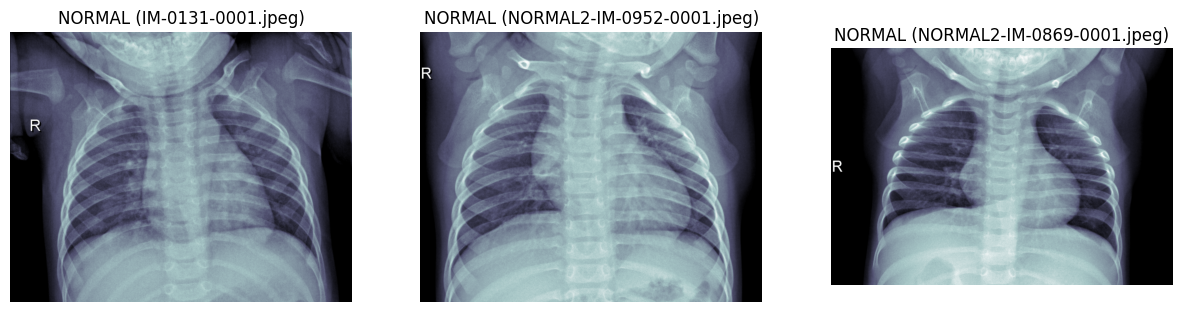

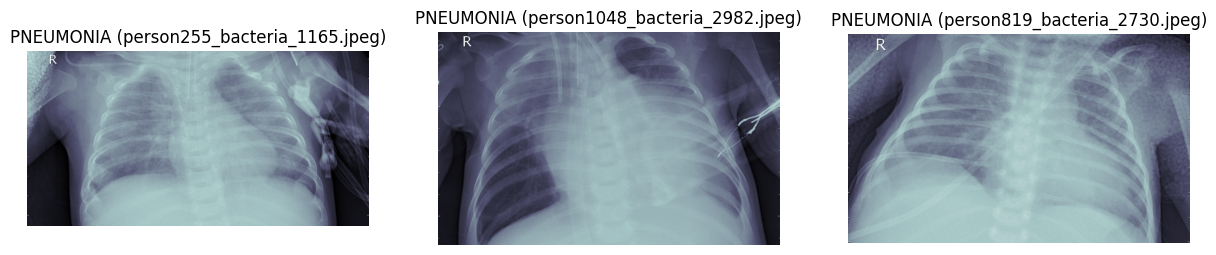

In [5]:
def display_random_images(basepath, dataset_type,label,num_images=3):
    sample_image_files = random.sample(data_files[dataset_type][label],num_images)
    fig,axs = plt.subplots(1, num_images,figsize=(15,5))
    for i in range(len(sample_image_files)):
        imagepath = os.path.join(basepath,dataset_type,label.upper(),sample_image_files[i])
        with Image.open(imagepath) as img:
            axs[i].imshow(img,cmap='bone')
            axs[i].set_title(f'{label} ({sample_image_files[i]})')
            axs[i].axis('off')
    plt.show()
    
display_random_images(base_data_dir,'train','NORMAL',3) 
display_random_images(base_data_dir,'train','PNEUMONIA',3) 

In [6]:
# some info about image sizes
for data_type in data_files:
    for data_cat in data_files[data_type]:
        size2D = {}
        minsz = float('inf')
        minsize2D = (float('inf'),float('inf'))
        maxsz = 0
        maxsize2D = (0,0)
        channels = []   
        for file in data_files[data_type][data_cat]:
            imagepath = os.path.join(base_data_dir,data_type,data_cat,file)
            with Image.open(imagepath) as img:
                sz = img.size[0]*img.size[1]
                if sz < minsz:
                    minsz = sz
                    minsize2D = img.size
                if sz > maxsz:
                    maxsz = sz
                    maxsize2D = img.size
                if img.size not in size2D:
                    size2D[img.size] = 0
                size2D[img.size] += 1
                if img.mode not in channels:
                    channels.append(img.mode)

        print(f"{data_type}, {data_cat}")
        keys_sorted = sorted(size2D.keys(), key=lambda k: size2D[k],reverse=True)
        for k in keys_sorted[:5]:
            print(f"images with size {k} appear {size2D[k]} times")
        print(f"min image size: {minsize2D}, max image size: {maxsize2D}, channel types: {channels}")


train, NORMAL
images with size (1472, 1171) appear 2 times
images with size (1480, 1228) appear 2 times
images with size (1364, 1148) appear 2 times
images with size (1616, 1318) appear 2 times
images with size (1284, 1013) appear 2 times
min image size: (912, 672), max image size: (2916, 2583), channel types: ['L']
train, PNEUMONIA
images with size (1072, 648) appear 7 times
images with size (1080, 728) appear 6 times
images with size (1008, 680) appear 5 times
images with size (976, 672) appear 5 times
images with size (1216, 872) appear 5 times
min image size: (384, 127), max image size: (2772, 2098), channel types: ['L', 'RGB']
test, NORMAL
images with size (2517, 1979) appear 2 times
images with size (1304, 952) appear 2 times
images with size (1168, 824) appear 2 times
images with size (1857, 1317) appear 1 times
images with size (2111, 1509) appear 1 times
min image size: (984, 496), max image size: (2517, 2713), channel types: ['L']
test, PNEUMONIA
images with size (1112, 736) 

In [7]:
keys_sorted = sorted(size2D.keys(), key=lambda k: size2D[k],reverse=True)
print(len(size2D))

8


### Data exploration summary
The dataset contains 5856 images, divided as follows:
- 1341 NORMAL and 3875 PNEUMONIA images in the training set
- 234 NORMAL and 390 PNEUMONIA images in the test set
- 8 NORMAL and 8 PNEUMONIA images in the validation set
- The classes are  imbalanced, there are almost 3 times more images labelled with PNEUMONIA compared to images labelled NORMAL in the train dataset
- The train:val:test split as the data is divided now is 89.1% train, 0.3% val, 10.7% test , which seems not to be in line with standard practices of for example 80:10:10. Especially the validation dataset seems too small. 
- Image sizes vary between roughly 380x125 and 2775 x 2100.
- most images are 8-bit greyscale JPEG images. However, in the train/PNEUMONIA set there are also some RGB JPEG images.